In [1]:
!pip3 install osmnx
!pip3 install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 831.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 553.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 622.7 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 763.4 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.3 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 2.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 3.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 1.6 MB/s eta 0:00:00a 0:00:01


In [2]:
import osmnx as ox
import networkx as nx

# Configure OSMnx
ox.config(use_cache=True, log_console=True)

In [4]:
# Download the street network for Milan
city_graph = ox.graph_from_place('Padua, Italy', network_type='walk')

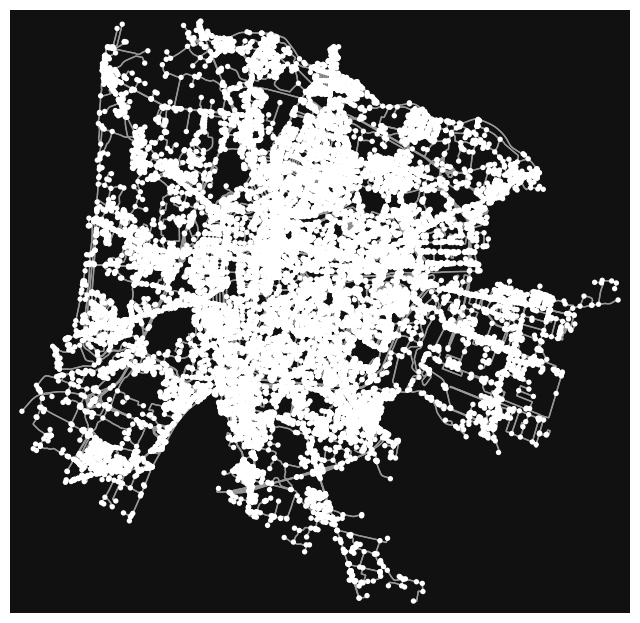

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
# Visualize the graph
ox.plot_graph(city_graph)

In [6]:
city_graph.shape

AttributeError: 'MultiDiGraph' object has no attribute 'shape'

In [ ]:
# Retrieve supermarkets in Milan
supermarkets = ox.geometries_from_place('Padua, Italy', tags={'shop': 'supermarket'})
pharmacies = ox.geometries_from_place('Padua, Italy', tags={'amenity': 'pharmacy'})
hospitals = ox.geometries_from_place('Padua, Italy', tags={'amenity': 'hospital'})

In [11]:
# Add supermarkets as nodes to the graph
for idx, row in supermarkets.iterrows():
    nearest_node = ox.nearest_nodes(city_graph, X=row['lon'], Y=row['lat'])
    city_graph.add_node(idx, pos=(row['lat'], row['lon']))
    city_graph.add_edge(idx, nearest_node)

# Add supermarkets as nodes to the graph
for idx, row in pharmacies.iterrows():
    nearest_node = ox.nearest_nodes(city_graph, X=row['lon'], Y=row['lat'])
    city_graph.add_node(idx, pos=(row['lat'], row['lon']))
    city_graph.add_edge(idx, nearest_node)

# Add supermarkets as nodes to the graph
for idx, row in hospitals.iterrows():
    nearest_node = ox.nearest_nodes(city_graph, X=row['lon'], Y=row['lat'])
    city_graph.add_node(idx, pos=(row['lat'], row['lon']))
    city_graph.add_edge(idx, nearest_node)

# Calculate edge weights (distances)
for u, v, data in city_graph.edges(data=True):
    data['weight'] = ox.distance.euclidean_dist_vec(city_graph.nodes[u]['y'], city_graph.nodes[u]['x'], city_graph.nodes[v]['y'], city_graph.nodes[v]['x'])

# Visualize the graph
ox.plot_graph(city_graph)

KeyError: 'lon'

In [14]:
type(supermarkets)

geopandas.geodataframe.GeoDataFrame

In [15]:
print(supermarkets.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 83 entries, ('node', 256072065) to ('way', 1204651301)
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   addr:housenumber      39 non-null     object  
 1   addr:postcode         23 non-null     object  
 2   addr:street           43 non-null     object  
 3   check_date            1 non-null      object  
 4   name                  82 non-null     object  
 5   opening_hours         41 non-null     object  
 6   shop                  83 non-null     object  
 7   website               21 non-null     object  
 8   wheelchair            17 non-null     object  
 9   geometry              83 non-null     geometry
 10  brand                 36 non-null     object  
 11  brand:wikidata        32 non-null     object  
 12  addr:city             29 non-null     object  
 13  brand:wikipedia       10 non-null     object  
 14  level            

In [32]:
supermarkets['geometry']['node'].get_coordinates()

,x,y
osmid,,
256072065,11.857927,45.410628
296955316,11.871986,45.448481
296963264,11.886786,45.440343
334511575,11.908236,45.412015
334512158,11.912572,45.403028
...,...,...
8668566924,11.890627,45.390014
8996209874,11.891555,45.435623
9026706317,11.890592,45.390038


In [ ]:
import osmnx as ox
from shapely.geometry import Point, LineString, nearest_points

# Configure OSMnx
ox.config(use_cache=True, log_console=True)

# Download the street network for Milan
city_graph = ox.graph_from_place('Milan, Italy', network_type='drive')

# Define a function to insert a service node into the graph
def insert_service_node(graph, service_type, service_lat, service_lon):
    # Find the nearest edge to the service location
    nearest_edge = ox.nearest_edges(graph, X=service_lon, Y=service_lat)

    # Get the geometry of the nearest edge
    u, v, key = nearest_edge
    edge_geom = graph.edges[u, v, key]['geometry']

    # Calculate the closest point on the edge to the service location
    point = Point(service_lon, service_lat)
    closest_point_on_edge = nearest_points(edge_geom, point)[0]

    # Create new edges with the split geometries
    edge_geom_1 = LineString([edge_geom.coords[0], (closest_point_on_edge.x, closest_point_on_edge.y)])
    edge_geom_2 = LineString([(closest_point_on_edge.x, closest_point_on_edge.y), edge_geom.coords[-1]])

    # Insert the new node into the graph
    new_node_id = max(graph.nodes()) + 1  # or any unique ID
    graph.add_node(new_node_id, x=closest_point_on_edge.x, y=closest_point_on_edge.y, service_type=service_type)

    # Remove the old edge and add the new edges
    graph.remove_edge(u, v)
    graph.add_edge(u, new_node_id, key=key, geometry=edge_geom_1)
    graph.add_edge(new_node_id, v, key=key, geometry=edge_geom_2)

    return new_node_id

# Example usage:
# Insert a supermarket node
supermarket_lat = 45.4654  # Replace with actual latitude
supermarket_lon = 9.1859   # Replace with actual longitude
insert_service_node(city_graph, 'supermarket', supermarket_lat, supermarket_lon)

# Insert a pharmacy node
pharmacy_lat = 45.4667  # Replace with actual latitude
pharmacy_lon = 9.1833   # Replace with actual longitude
insert_service_node(city_graph, 'pharmacy', pharmacy_lat, pharmacy_lon)

# ... and so on for other service types


In [ ]:
# Convert nodes and edges to Pandas DataFrames
nodes_df = pd.DataFrame.from_dict(dict(city_graph.nodes(data=True)), orient='index')
edges_df = nx.to_pandas_edgelist(city_graph)

# Export nodes and edges to CSV files
nodes_df.to_csv('nodes.csv', index_label='node_id')
edges_df.to_csv('edges.csv', index=False)